In [70]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.stats import gaussian_kde

class PolymerMotion:
    def __init__(self, num_particles, spring_constants, mass=1.0, dt=0.01, total_time=10):
        self.num_particles = num_particles
        self.spring_constants = spring_constants
        self.mass = mass
        self.dt = dt
        self.total_time = total_time

        # Initialize positions and velocities
        self.positions = np.random.rand(num_particles, 2)  # Random initial positions in 2D
        self.velocities = np.zeros((num_particles, 2))  # Start with zero velocity
        self.time_steps = int(total_time / dt)  # Total number of time steps
        self.trajectory = np.zeros((self.time_steps, num_particles, 2))  # Store trajectory

    def forces(self):
        # Calculate the spring forces
        F = np.zeros((self.num_particles, 2))
        for i in range(self.num_particles):
            for j in range(i + 1, self.num_particles):
                # Calculate the spring force based on Hooke's law
                displacement = self.positions[j] - self.positions[i]
                distance = np.linalg.norm(displacement)
                if distance > 0:
                    spring_force = self.spring_constants[i] * displacement / distance
                    F[i] += spring_force
                    F[j] -= spring_force  # Action-Reaction pair
        return F

    def motion_equations(self, y, t):
        # Unpack positions and velocities
        positions = y[:self.num_particles * 2].reshape((self.num_particles, 2))
        velocities = y[self.num_particles * 2:].reshape((self.num_particles, 2))
        
        # Calculate forces
        F = self.forces()
        
        # Equations of motion
        dydt = np.zeros_like(y)
        dydt[:self.num_particles * 2] = velocities.flatten()  # d(position)/dt = velocity
        dydt[self.num_particles * 2:] = (F / self.mass).flatten()  # d(velocity)/dt = force/mass
        
        return dydt

    def simulate(self):
        # Initial state vector: [positions, velocities]
        initial_conditions = np.hstack((self.positions.flatten(), self.velocities.flatten()))
        t = np.linspace(0, self.total_time, self.time_steps)
        
        # Integrate the equations of motion
        solution = odeint(self.motion_equations, initial_conditions, t)
        
        # Extract positions from the solution
        positions = solution[:, :self.num_particles * 2].reshape((-1, self.num_particles, 2))
        self.trajectory = positions  # Store the trajectory
        return t, positions

    def generate_transition_matrix(self):
        # Create a transition matrix based on the entire trajectory
        transition_matrix = np.zeros((self.num_particles, self.num_particles))
        
        # Calculate cumulative displacement over the trajectory
        cumulative_displacements = np.zeros((self.num_particles, self.num_particles))
        for t in range(1, self.time_steps):
            for i in range(self.num_particles):
                for j in range(self.num_particles):
                    if i != j:
                        displacement = np.linalg.norm(self.trajectory[t, i] - self.trajectory[t, j])
                        cumulative_displacements[i, j] += displacement

        # Use cumulative displacement to adjust transition probabilities (closer -> higher probability)
        for i in range(self.num_particles):
            row_sum = cumulative_displacements[i].sum()
            if row_sum == 0:
                transition_matrix[i] = np.ones(self.num_particles) / self.num_particles
            else:
                for j in range(self.num_particles):
                    if i != j and cumulative_displacements[i, j] > 0:
                        transition_matrix[i, j] = 1 / cumulative_displacements[i, j]

        # Normalize rows to sum to 1
        row_sums = transition_matrix.sum(axis=1)
        for i in range(self.num_particles):
            if row_sums[i] > 0:
                transition_matrix[i] /= row_sums[i]
            else:
                transition_matrix[i] = np.ones(self.num_particles) / self.num_particles

        return transition_matrix

    def sample_random_walk(self, transition_matrix, num_steps, initial_state=0):
        state = initial_state
        visited_states = [state]

        for _ in range(num_steps):
            state = np.random.choice(self.num_particles, p=transition_matrix[state])
            visited_states.append(state)

        return visited_states

    def plot_probability_distribution(self, visited_states):
        # Create a histogram of visited states
        plt.figure(figsize=(10, 6))
        plt.hist(visited_states, bins=np.arange(self.num_particles + 1) - 0.5, density=True, alpha=0.6, color='b', edgecolor='black')
        plt.title('Probability Distribution from Random Walk')
        plt.xlabel('Node')
        plt.ylabel('Probability')
        plt.xticks(np.arange(self.num_particles))
        plt.grid()
        plt.xlim(-0.5, self.num_particles - 0.5)  # Set limits to match the bins
        plt.show()

In [71]:
# Parameters
num_nodes = 10
spring_constants = np.random.rand(num_nodes)  # Random spring constants
mass = 1.0
dt = 0.01
total_time = 10  # Total simulation time
num_steps = 1000  # Number of steps for the random walk

# Initialize the PolymerMotion
polymer_motion = PolymerMotion(num_nodes, spring_constants, mass, dt, total_time)

# Simulate the polymer motion
time, positions = polymer_motion.simulate()

# Generate the transition matrix using the last positions
transition_matrix = polymer_motion.generate_transition_matrix()
print("Transition Matrix:\n", transition_matrix)

Transition Matrix:
 [[0.         0.04832183 0.04688129 0.08376651 0.1723927  0.26601808
  0.06393668 0.12041083 0.11689152 0.08138056]
 [0.0708905  0.         0.13992529 0.12274682 0.06343388 0.07370705
  0.29010266 0.05886337 0.08849244 0.09183799]
 [0.08260122 0.16805    0.         0.09641925 0.06815848 0.09370895
  0.16624273 0.08071852 0.08225395 0.1618469 ]
 [0.10166705 0.10154895 0.06641813 0.         0.10021897 0.09139113
  0.15010533 0.06345416 0.24758657 0.07760972]
 [0.22562453 0.05659057 0.05062913 0.1080706  0.         0.13690815
  0.07151353 0.09818555 0.17895915 0.07351879]
 [0.26874637 0.05075699 0.05373108 0.07607215 0.10568012 0.
  0.06767951 0.17276656 0.09136786 0.11319935]
 [0.07842005 0.24254044 0.1157265  0.15169225 0.06701899 0.08216803
  0.         0.06093921 0.10069597 0.10079856]
 [0.17063095 0.05685816 0.06492    0.0740871  0.10630958 0.24233744
  0.07040638 0.         0.08517747 0.12927292]
 [0.13608703 0.07022557 0.0543505  0.23749311 0.15919162 0.10529208


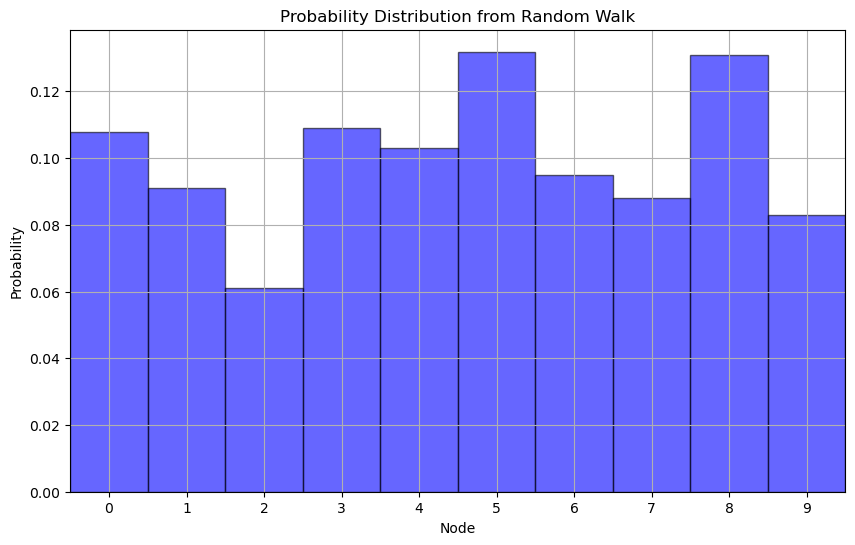

In [72]:
# Simulate a random walk
visited_states = polymer_motion.sample_random_walk(transition_matrix, num_steps)

# Plot the probability distribution of visited states
polymer_motion.plot_probability_distribution(visited_states)